In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\BMI_cage_g2F\mouse_g2FB\20221111\analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\BMI_cage_g2F\mouse_g2FB\20221111\analysis_data\day0_analysis\suite2p\plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [6]:
DEVICE = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)


In [7]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [8]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [11]:
Fneu.shape

(3846, 101000)

In [12]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [13]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [14]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [15]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(
    F_toUse,
    kernel=kernel_smoothing,
    axis=1,mode='same',
    multicore_pref=True,
    verbose=True
).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_smooth + channelOffset_correction,
    Fneu=Fneu_toUse + channelOffset_correction,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    multicore_pref=True,
    verbose=True
)
# Threshold for nonnegativity
dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

ThreadPool elapsed time : 0.04 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.09 seconds
Calculated dFoF. Total elapsed time: 6.0 seconds


In [16]:
# Test out rolling subtraction of the 10th percentile of the daa to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

# dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)
dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_rq_multicore(dFoF, ptile=ptile, window=window)
dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0, a_max=None)

### Look at rastermap

In [ ]:
import rastermap

In [ ]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [ ]:
# rmap.fit(dFoF_sub_ptile)
rmap.fit(np.clip(dFoF_sub_ptile, a_min=0, a_max=1))
# rmap.fit(scipy.stats.zscore(dFoF))

In [ ]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
# plt.imshow(np.clip(scipy.stats.zscore(dFoF_sub_ptile, axis=1), -1,1)[rmap.isort], aspect='auto', vmax=1)
plt.imshow(dFoF_sub_ptile_clipped[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)
# plt.imshow(scipy.stats.zscore(dFoF)[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)

In [ ]:
dFoF_pTileSub_rnsrWeighted = dFoF_sub_ptile_clipped/tqm['tqm']['metrics']['peter_noise_levels'][tqm['iscell_tqm']][:,None]**0.3

In [ ]:
discount = tqm['tqm']['metrics']['rich_nsr'][tqm['iscell_tqm']]

In [ ]:
discount = scipy.special.softmax(tqm['tqm']['metrics']['rich_nsr'][tqm['iscell_tqm']]/10)

In [ ]:
dFoF_pTileSub_rnsrWeighted = dFoF_sub_ptile_clipped

In [ ]:
dFoF_pTileSub_rnsrWeighted = dFoF_sub_ptile_clipped/discount[:,None]**0.3

In [ ]:
dFoF_pTileSub_rnsrWeighted = (dFoF_sub_ptile_clipped/dFoF_sub_ptile_clipped.std(1, keepdims=True))/discount[:,None]**1

In [ ]:
plt.figure()
plt.plot(discount)

In [ ]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    dFoF_pTileSub_rnsrWeighted,
    aspect='auto',
    vmin=0, 
    vmax=10000,
)

# Run NMF

In [ ]:
# indices_cropped = np.arange(int(Fs*60*23),dFoF_sub_ptile.shape[1])

In [ ]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))

In [18]:
tl.set_backend('pytorch')

In [19]:
neural_data_toUse = tl.tensor(neural_data_toUse).to('cuda')

In [20]:
# Roll a dice and wish for luck
rank = 10

In [21]:
factors_nmf = tl.decomposition.non_negative_parafac(
            neural_data_toUse,
            rank=rank,
            n_iter_max=500,
            init='random',
            svd='numpy_svd', 
            tol=1e-06,
        #     random_state=None,
            verbose=0,
        #     normalize_factors=False,
        #     return_errors=False,
        #     mask=None,
        #     cvg_criterion='abs_rec_error',
        #     fixed_modes=None
        )

In [22]:
factors_temporal_nmf = np.array(factors_nmf.factors[1].to('cpu')).T

# Run Regression
Regress z-scored NMF temporal factors onto z-scored neural data itself

In [25]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score NMF outputsneural_data_toUse 
factors_temporal_nmf_zscore = scipy.stats.zscore(factors_temporal_nmf[:,indices_to_use],axis=1)
# neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T

In [29]:
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|███████████████████████████████████████████████████████████████████████| 101000/101000 [00:07<00:00, 12944.40it/s]
D:\RH_local\github\basic_neural_processing_modules\welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [ ]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    neural_data_toUse_zscore,
    aspect='auto',
    vmin=-1, 
    vmax=2,
)

In [30]:
# # OLS Regression
# theta, factors_temporal_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
# factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# # Ridge Regression
# theta, factors_temporal_regression, bias = linear_regression.Ridge(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T, lam=100000)
# factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# ElasticNet Regression
elr = sklearn.linear_model.ElasticNet(
    alpha=0.1,
    l1_ratio=0.05, 
    fit_intercept=False,
#     normalize='deprecated',
#     precompute=False,
    max_iter=1000, 
#     copy_X=True, 
    tol=0.0001,
#     warm_start=False, 
    positive=False,
    random_state=42, 
    selection='cyclic',
#     verbose=True,
)
elr.fit(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)

theta = elr.coef_.T
factors_temporal_regression = elr.predict(neural_data_toUse_zscore.T).T

In [ ]:
plt.figure()
plt.plot(np.arange(factors_temporal_nmf_zscore.shape[1])/Fs,  factors_temporal_nmf_zscore.T + 10*np.arange(rank)[None,:], alpha=0.3);
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_regression.shape[1])/Fs,  factors_temporal_regression.T + 10*np.arange(rank)[None,:]);

In [ ]:
similarity.EV(factors_temporal_nmf_zscore.T, factors_temporal_regression.T)

In [31]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T.astype(np.float32), factors_temporal_nmf_zscore.T.astype(np.float32))
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]
(pairwise > ev_threshold).sum()

10

In [ ]:
pairwise

In [32]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_temporal_tokeep,  np.ones(rank, bool))
# _, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))

<IPython.core.display.Javascript object>


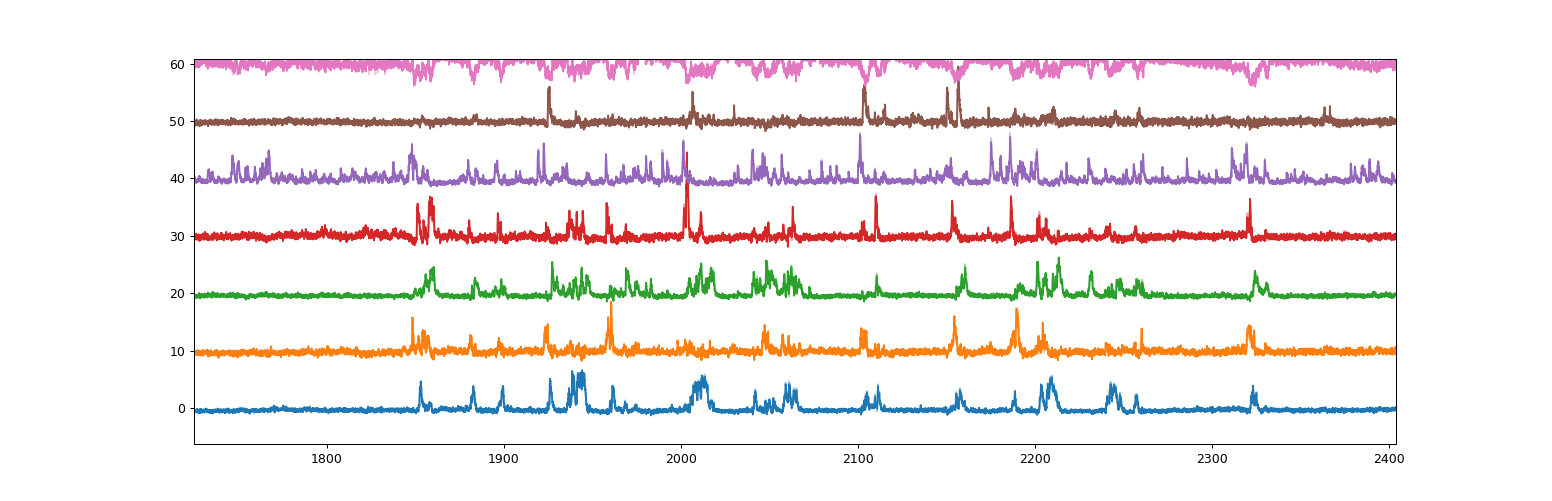

In [53]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_nmf_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank));

<IPython.core.display.Javascript object>


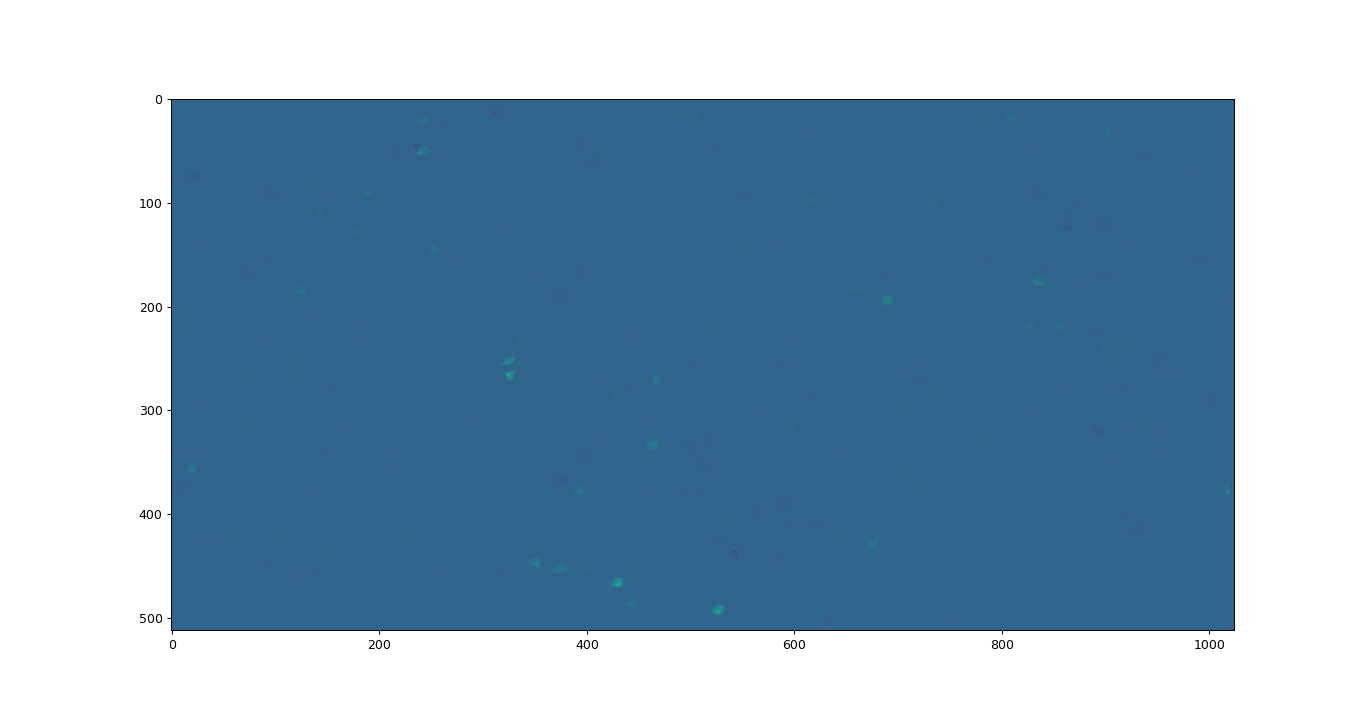

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [54]:
weights = theta[:,np.argsort(evrs)[::-1]]
# weights = theta
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min(), sf_weights.max()]
)

# Run Orthogonalization

In [35]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 1 index explains 0.029590606689453125 of the variance in neural data
Factor at 2 index explains 0.019335389137268066 of the variance in neural data
Factor at 9 index explains 0.017875969409942627 of the variance in neural data
Factor at 7 index explains 0.01414114236831665 of the variance in neural data
Factor at 4 index explains 0.01267707347869873 of the variance in neural data
Factor at 0 index explains 0.012088239192962646 of the variance in neural data
Factor at 6 index explains 0.011514008045196533 of the variance in neural data
Factor at 8 index explains 0.009672403335571289 of the variance in neural data
Factor at 3 index explains 0.00936734676361084 of the variance in neural data


<IPython.core.display.Javascript object>


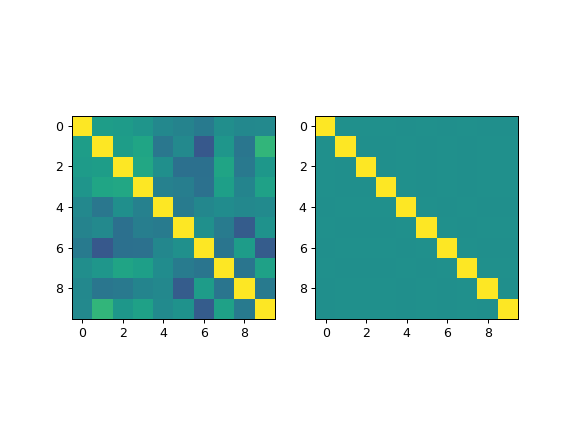

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [37]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [38]:
np.sort(evrs)

array([0.00762004, 0.00936735, 0.0096724 , 0.01151401, 0.01208824,
       0.01267707, 0.01414114, 0.01787597, 0.01933539, 0.02959061])

# Run Regression Pt 2

In [39]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [41]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_orth,  np.ones(num_factors, bool))

<IPython.core.display.Javascript object>


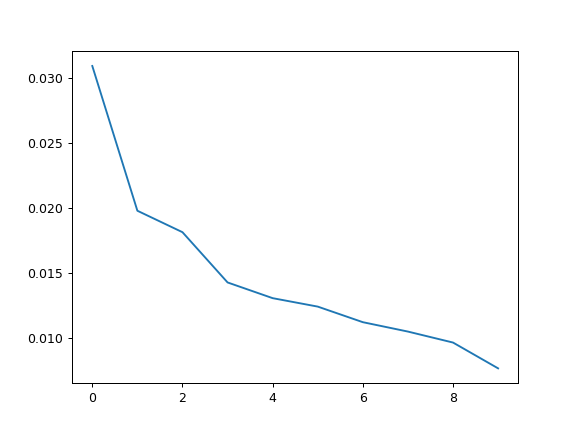

In [42]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

# Visualize

<IPython.core.display.Javascript object>


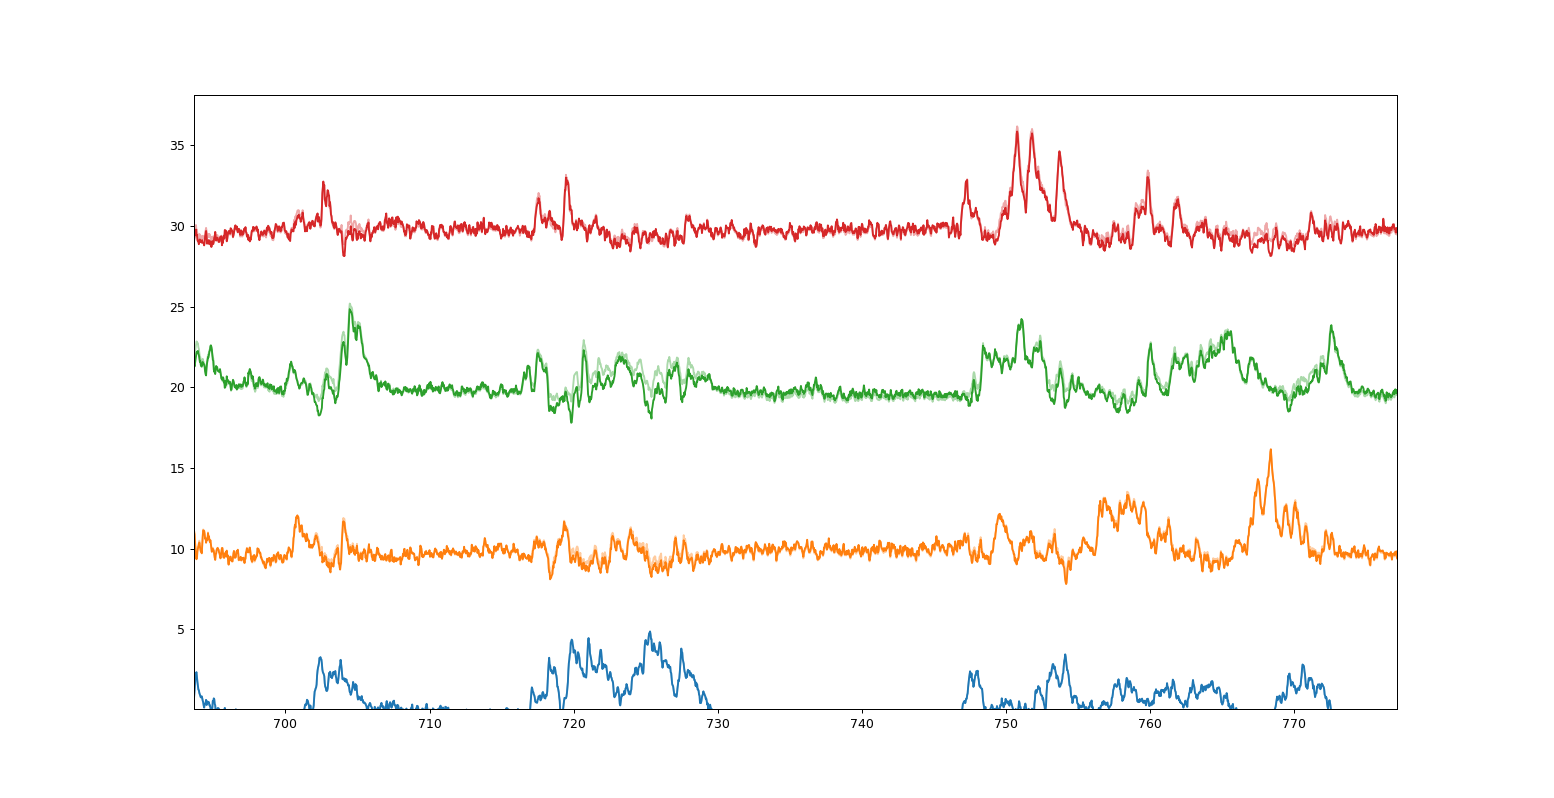

In [43]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank))

<IPython.core.display.Javascript object>


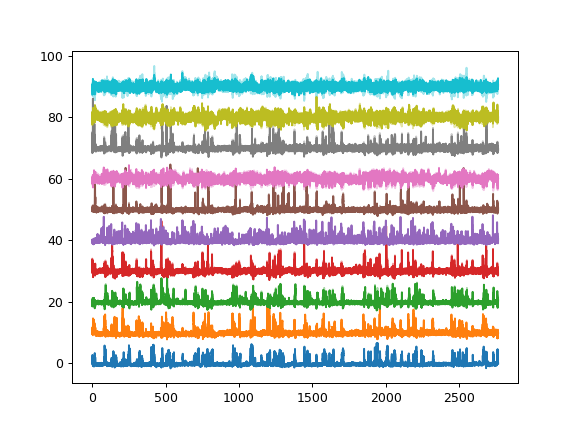

In [44]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank))

<IPython.core.display.Javascript object>


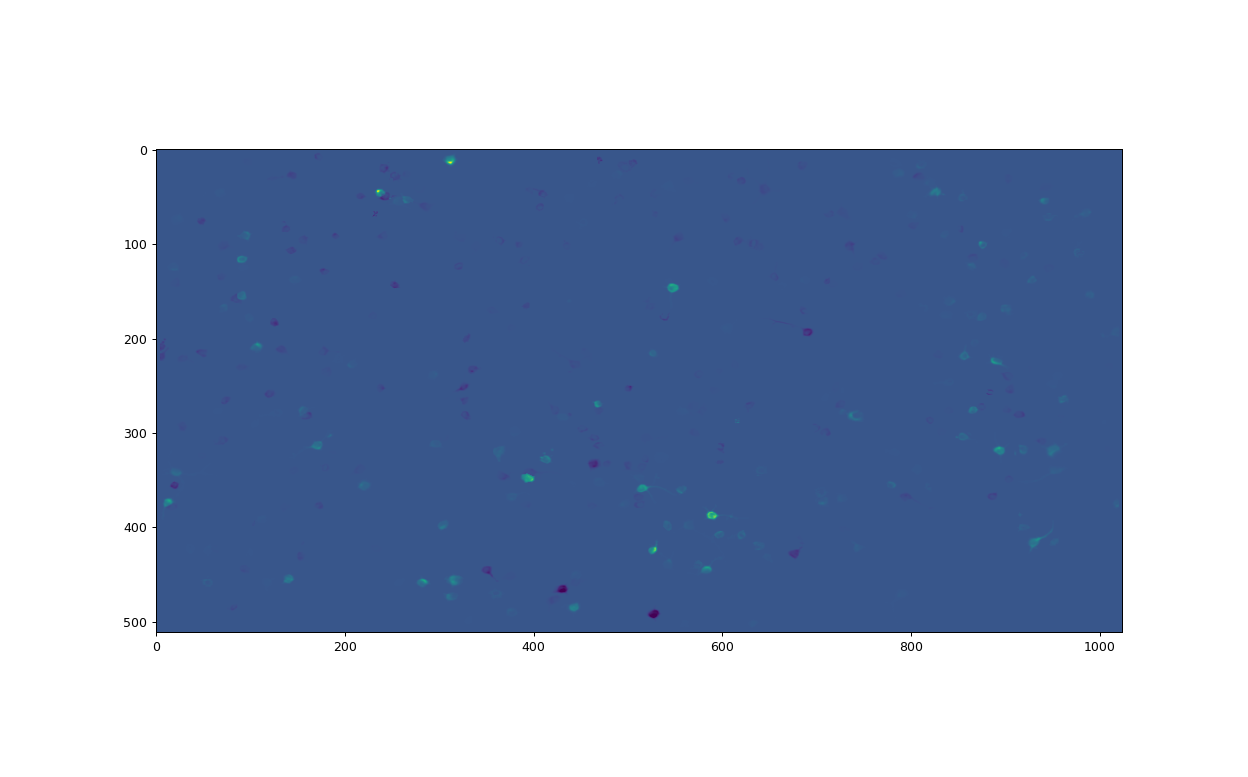

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [45]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(sf_weights)

<IPython.core.display.Javascript object>


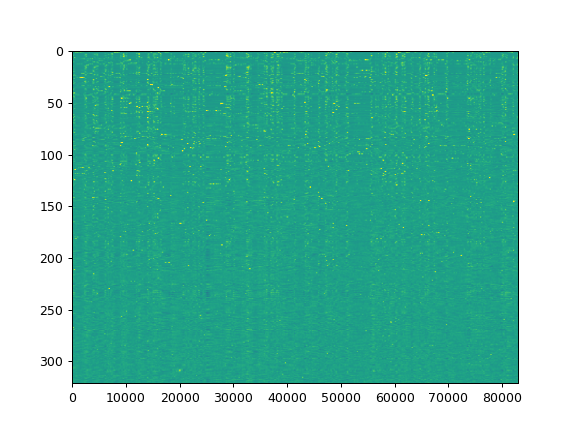

In [46]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

<IPython.core.display.Javascript object>


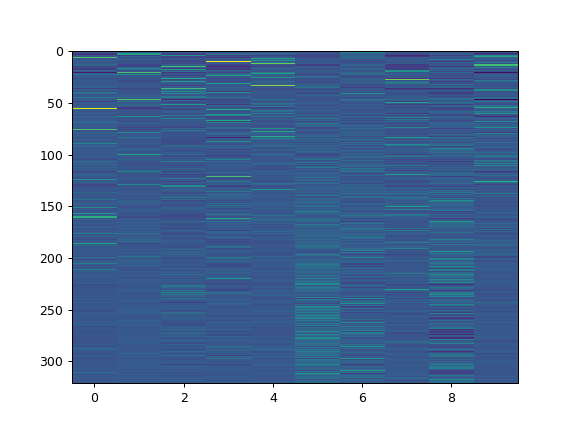

In [47]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

# Save it all

In [49]:
factor_to_use = 0 # 0-indexed
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
    "factors_temporal": factors_temporal_tokeep,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [ ]:
import numpy as np

In [ ]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_3/mouse_B/20221020/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [ ]:
data.keys()

In [ ]:
# weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [ ]:
components , scores , explained_variance_ratio_ , stds = decomposition.simple_pca(neural_data_toUse.T.cpu().numpy() , n_components=None , mean_sub=True, zscore=False, plot_pref=True , n_PCs_toPlot=2)

In [ ]:
factors_orth_regression.shape

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(factors_orth_regression.shape[0], 2, sharex='row')
for ii in range(axs.shape[0]):
    axs[ii,0].plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii,1].plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, scores[:,ii][indices_to_use])

In [ ]:
import rastermap

In [ ]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
#     nPC=200,
#     init='pca',
#     alpha=1.0,
#     K=1.0,
#     mode='basic',
#     verbose=True,
#     annealing=True,
#     constraints=2,
)

In [ ]:
# embedding = rmap.fit_transform(neural_data_toUse.cpu().numpy())
# embedding = rmap.fit_transform(dFoF)
embedding = rmap.fit_transform(np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression]))

In [ ]:
plt.figure()
plt.hist(embedding, 400);
plt.hist(embedding[-10:], 100);

In [ ]:
plt.figure()
plt.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
plt.xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
#ax1.set_xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))
ax2.plot(factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
ax2.plot(factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

In [ ]:
indices_to_use.shape